<a href="https://colab.research.google.com/github/quinn-dougherty/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/module3-quantile-regression/Copy_of_LS_DS1_233_Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf


df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [0]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24       4.859812
25       4.997212
26       5.068904
27       5.198497
28       4.927254
29       4.691348
           ...   
43794    4.369448
43795    3.555348
43796    3.258097
43797    2.995732
43798    2.079442
43799    2.772589
43800    2.302585
43801    2.397895
43802    2.995732
43803    2.197225
43804    2.079442
43805    2.197225
43806    2.079442
43807    2.079442
43808    2.079442
43809    2.079442
43810    1.945910
43811    2.484907
43812    2.833213
43813    2.397895
43814    2.197225
43815    2.397895
43816    2.079442
43817    2.197225
43818    2

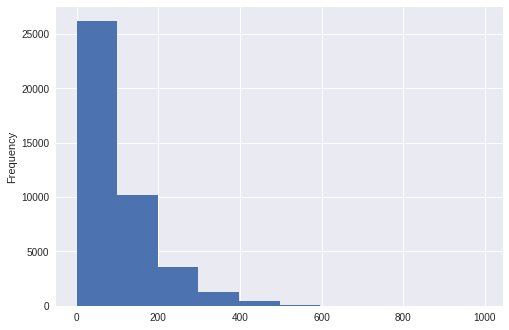

In [0]:
df['pm2.5'].plot.hist();

np.log(df['pm2.5'])

In [0]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

In [0]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# they also support * for interaction terms, polynomiasl 
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + cbwd + Iws + Is + Ir


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1791
Model:                       QuantReg   Bandwidth:                       7.993
Method:                 Least Squares   Sparsity:                        128.1
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        17:29:32   Df Residuals:                    41742
                                        Df Model:                           14
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.61e-05     23.232      0.000       0.000       0.000
cbwd[T.NW]    -1.4760      1.124     -1.313      0.189      -3.679       0.727
cbwd[T.SE]    29.2837      1.107     26.463      0.000      27.115      31.453
cbwd[T.cv]    28.8418      1.157     24.923      0.000      26.574      31.110
No         -6.802e-05   2.56e-05     -2.654      0.008      -0.000   -1.78e-05
year           0.8582      0.030     28.962      0.000       0.800       0.916
month         -0.7731      0.100     -7.760      0.000      -0.968      -0.578
day            0.4509      0.036     12.613      0.000       0.381       0.521
hour           0.8729      0.049     17.922      0.000       0.777       0.968
DEWP           3.1508      0.046     68.424      0.000       3.061       3.241
TEMP          -4.5503      0.058    -79.010      0.000      -4.663      -4.437
PRES          -1.5942      0.058    -27.318      0.000      -1.709      -1.480
Iws           -0.1008      0.007    -14.158      0.000      -0.115      -0.087
Is            -2.2468      0.408     -5.508      0.000      -3.046      -1.447
Ir            -4.6240      0.225    -20.514      0.000      -5.066      -4.182
==============================================================================

The condition number is large, 3.45e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [0]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Sun, 20 Jan 2019   No. Observations:                41757
Time:                        23:01:53   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.803      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [0]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

(0.5, 0.1447879336023583)
(0.51, 0.1453046499109799)
(0.52, 0.1457984456251047)
(0.53, 0.14627848333343263)
(0.54, 0.1467640446791706)
(0.55, 0.14733094668790292)
(0.56, 0.14787821797693512)
(0.57, 0.14840185621049273)
(0.58, 0.14892138273908107)
(0.59, 0.14946793972061212)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.6, 0.1500450836285967)
(0.61, 0.15066665485612274)
(0.62, 0.15131550520931825)
(0.63, 0.15201598245712966)
(0.64, 0.152815632180745)
(0.65, 0.15360133883660188)
(0.66, 0.15440046026580068)
(0.67, 0.15521251759239985)
(0.68, 0.15607615678951559)
(0.69, 0.15692695615298136)
(0.7, 0.1577663389046554)
(0.71, 0.15865286212994567)
(0.72, 0.15961363441229715)
(0.73, 0.16062991121153458)
(0.74, 0.1617151201897239)
(0.75, 0.16280951619867146)
(0.76, 0.16394259393342125)
(0.77, 0.16517451474458056)
(0.78, 0.1664423443710097)
(0.79, 0.16770815353095714)


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.8, 0.16904227356438506)
(0.81, 0.17037126968955685)
(0.82, 0.17195593122357777)
(0.83, 0.17383892606382623)
(0.84, 0.17599918426382777)
(0.85, 0.17817588507328963)
(0.86, 0.18047434708570964)
(0.87, 0.18274842963575832)
(0.88, 0.1850748927825704)
(0.89, 0.18767194363846373)
(0.9, 0.1899871464061209)
(0.91, 0.19205778885867675)
(0.92, 0.19409258046839573)
(0.93, 0.1960928580149024)
(0.94, 0.1990718585613529)
(0.95, 0.20306510227274233)
(0.96, 0.20828854295993626)
(0.97, 0.21268428179968246)
(0.98, 0.21668870123970496)
(0.99, 0.21742941318156628)


In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2292
Model:                       QuantReg   Bandwidth:                      0.1012
Method:                 Least Squares   Sparsity:                        2.806
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        17:50:35   Df Residuals:                    41751
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2444      0.013    318.116      0.000       4.218       4.271
DEWP           0.0722      0.001     96.780      0.000       0.071       0.074
TEMP          -0.0701      0.001    -83.629      0.000      -0.072      -0.068
Ir            -0.1079      0.004    -29.400      0.000      -0.115      -0.101
hour           0.0215      0.001     23.206      0.000       0.020       0.023
Iws           -0.0040      0.000    -36.706      0.000      -0.004      -0.004
==============================================================================
"""

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv' 

df = pd.read_csv(url)

df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [0]:

df = df.replace('?', np.nan)


df.shape, df.isna().sum()

hasna = ['Age', 'HoursPerWeek', 'TotalHours']

for feat in hasna: 
  df[feat] = pd.to_numeric(df[feat])
  
df[hasna].head()

df.isna().sum(), df.dtypes, df.shape


df.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3340.000000,3339.000000,3338.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,21.647904,15.910752,960.421809,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,4.206341,11.962912,17318.133922,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
max,10095.000000,8.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001752,10.000000,0.003019,0.004041,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


In [0]:
from sklearn.linear_model import LinearRegression 

dff = df._get_numeric_data().dropna()
X = df.drop('APM', axis='columns')
y = df.APM

linear_reg = LinearRegression().fit(X,y)
linear_reg

ValueError: ignored

In [0]:
from sklearn.linear_model import LogisticRegression

## what fastest 10% of starcraft players like? 
## wquantile regression with q=0.9

quant_formula  = 'APM ~ ' + ' + '.join(df.drop('APM', axis='columns').columns)

quant_mod = smf.quantreg(quant_formula, data=dff) 
quant_reg = quant_mod.fit(q=0.9)
quant_reg.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    APM   Pseudo R-squared:               0.4076
Model:                       QuantReg   Bandwidth:                       6.911
Method:                 Least Squares   Sparsity:                        179.3
Date:                Wed, 23 Jan 2019   No. Observations:                 3338
Time:                        18:33:25   Df Residuals:                     3318
                                        Df Model:                           19
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1786     22.328      0.008      0.994     -43.599      43.956
GameID                   0.0016      0.000      4.316      0.000       0.001       0.002
LeagueIndex             13.8712      1.115     12.443      0.000      11.685      16.057
Age                      0.5439      0.242      2.252      0.024       0.070       1.017
HoursPerWeek             0.6801      0.072      9.432      0.000       0.539       0.821
TotalHours            7.858e-05   2.16e-05      3.645      0.000    3.63e-05       0.000
SelectByHotkeys          0.0433    564.600   7.67e-05      1.000   -1106.956    1107.042
AssignToHotkeys       8.993e-05    153.980   5.84e-07      1.000    -301.906     301.906
UniqueHotkeys            3.5928      0.461      7.801      0.000       2.690       4.496
MinimapAttacks           0.0001    229.321   5.63e-07      1.000    -449.624     449.625
MinimapRightClicks       0.0027   2886.156   9.21e-07      1.000   -5658.823    5658.828
NumberOfPACs            -0.0021   3483.391  -5.96e-07      1.000   -6829.815    6829.811
GapBetweenPACs           0.2392      0.078      3.060      0.002       0.086       0.393
ActionLatency           -0.8386      0.160     -5.225      0.000      -1.153      -0.524
ActionsInPAC            15.1596      0.938     16.164      0.000      13.321      16.998
TotalMapExplored         0.8265      0.162      5.109      0.000       0.509       1.144
WorkersMade              0.0006   1991.420   3.05e-07      1.000   -3904.535    3904.536
UniqueUnitsMade         -1.3534      0.633     -2.139      0.033      -2.594      -0.113
ComplexUnitsMade        -0.0002     72.101     -3e-06      1.000    -141.368     141.367
ComplexAbilitiesUsed -2.925e-05     61.714  -4.74e-07      1.000    -121.002     121.001
========================================================================================

The condition number is large, 2.16e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

np.sqrt(0.4076)

0.6384355879804947

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [69]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf

from scipy.stats import percentileofscore
from numpy.testing import assert_almost_equal

bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [70]:
bwt_df.dtypes, bwt_df.isna().sum(), bwt_df.dtypes, bwt_df.isna().sum()

bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [71]:
#First, identify an appropriate q (quantile) to target a cutoff of 90 ounces - 
# babies above that birth weight are generally healthy/safe, babies below are at-risk.

q_90_test = 0.055 #percentileofscore(bwt_df.bwt, 90)/100

q_90 = np.divide(percentileofscore(bwt_df.bwt, 90), 100)

bwt_df.bwt.quantile(q=q_90)


#0.5-distn == q_90



90.0

In [72]:

quant_formula  = 'bwt ~ ' + ' + '.join(bwt_df.drop(['bwt'], axis='columns').columns)

quant_mod = smf.quantreg(quant_formula, data=bwt_df) 
quant_reg = quant_mod.fit(q=q_90)
quant_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1989
Model:                       QuantReg   Bandwidth:                       6.228
Method:                 Least Squares   Sparsity:                        132.4
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        22:35:20   Df Residuals:                     1167
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3321     32.589     -2.956      0.003    -160.271     -32.393
gestation      0.4789      0.089      5.381      0.000       0.304       0.654
parity        -3.2501      2.338     -1.390      0.165      -7.837       1.337
age           -0.0836      0.172     -0.486      0.627      -0.421       0.254
height         1.2308      0.437      2.817      0.005       0.374       2.088
weight        -0.1191      0.058     -2.048      0.041      -0.233      -0.005
smoke         -8.7485      1.855     -4.716      0.000     -12.388      -5.109
==============================================================================

The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
bwt_df['weirdfeat'] = bwt_df.age * (bwt_df.parity - 2)

bwt_df['age_per_weight'] = np.divide(bwt_df.age, bwt_df.weight)

bwt_df['apw_times_parityplus1'] = bwt_df.age_per_weight * (bwt_df.parity+1)

bwt_df['BMI'] = np.divide(bwt_df.weight, bwt_df.height**2) * 703 

bwt_df['weirdishfeat'] = bwt_df.gestation ** (bwt_df.parity+1)

bwt_df['gestation_squrd'] = bwt_df.gestation ** 2

#bwt_df['weirdfeat'] = bwt_df.weirdfeat + 3

quant_formula  = 'bwt ~ ' + ' + '.join(bwt_df.drop(['bwt', 'weirdfeat', 'apw_times_parityplus1', 'weirdishfeat'], axis='columns').columns)

quant_mod = smf.quantreg(quant_formula, data=bwt_df) 
quant_reg = quant_mod.fit(q=q_90)
quant_reg.summary()

#bwt_df.weirdfeat

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2113
Model:                       QuantReg   Bandwidth:                       6.217
Method:                 Least Squares   Sparsity:                        119.3
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        22:53:55   Df Residuals:                     1164
                                        Df Model:                            9
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.3958    157.447     -0.003      0.998    -309.307     308.515
gestation           4.0762      0.575      7.093      0.000       2.949       5.204
parity             -4.0145      2.207     -1.819      0.069      -8.345       0.316
age                -0.2131      0.830     -0.257      0.797      -1.841       1.415
height             -7.9578      2.069     -3.845      0.000     -12.018      -3.898
weight              2.1736      0.494      4.396      0.000       1.204       3.144
smoke              -7.5925      1.752     -4.333      0.000     -11.031      -4.154
age_per_weight     -0.1870    105.916     -0.002      0.999    -207.994     207.620
BMI               -13.5631      2.770     -4.896      0.000     -18.999      -8.127
gestation_squrd    -0.0064      0.001     -5.793      0.000      -0.009      -0.004
===================================================================================

The condition number is large, 1.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0    866
1    308
Name: parity, dtype: int64

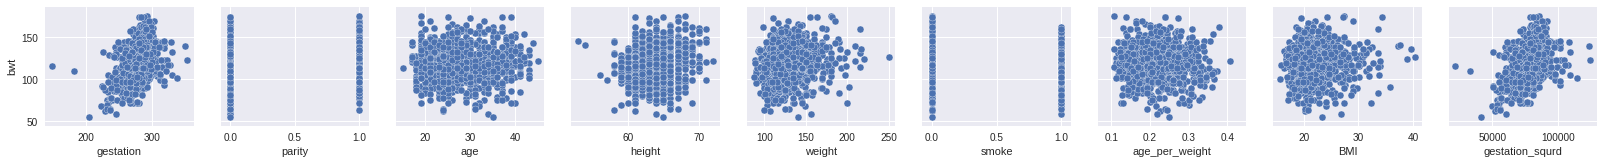

In [91]:
from seaborn import pairplot

pairplot(data=bwt_df, 
         x_vars=bwt_df.drop(['bwt', 'weirdfeat', 'apw_times_parityplus1', 
                             'weirdishfeat'], axis='columns').columns, 
         y_vars='bwt');

## Gestation is our most reliable feature.
- it's errors are consistently reasonable, and it's p-value is consistently very small, adding gestation ** 2 improved the model. 
## BMI is better
- the model is better with BMI than without 

## Adding BMI made age_per_weight less effective 
- age_per_weight's error and p-value both went up when BMI was added. 

# Obviously, _don't smoke_ 

In [0]:
'''
    What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
    What can expectant mothers be told to help mitigate this risk?
'''

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model